In [1]:
from model import NeuralNetwork
from masks import Mask
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

The next steps are to import the dataset and create the training and test loop.
As training data I am going to use FashionMNIST.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

In [3]:
from tqdm.auto import tqdm

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        
        optimizer.step()

        # apply masks again in the case backpropagtion changed the weights 
        model.apply_masking()

        optimizer.zero_grad()

        """
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        """

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct, test_loss

c:\Users\timje\Documents\Studium\projectNIP2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize the masks that will be applied.

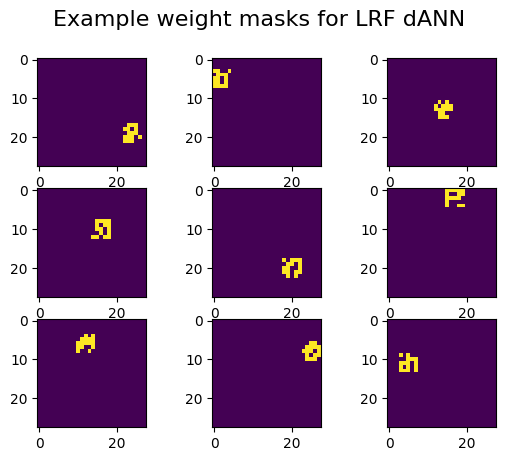

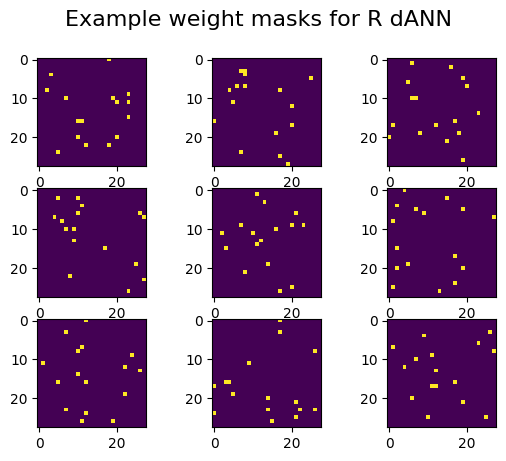

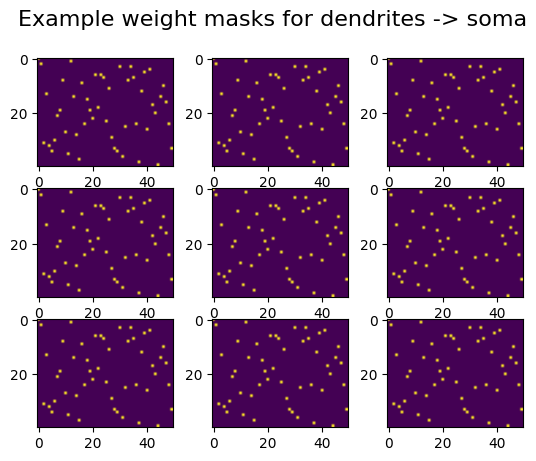

In [9]:
def plot_weights(matrix,title):
    fig, axs = plt.subplots(3,3)
    fig.suptitle(title, fontsize=16)
    counter = 0
    for i in range(3):
        
        for j in range(3):
            axs[i][j].imshow(np.reshape(matrix[counter], (28,28)))
            counter += 1


b = Mask.create_mask_input_to_dendrites(28*28,50, "local", 16)  
c = Mask.create_mask_input_to_dendrites(28*28,50,"random",16)
d = Mask.create_mask_dendrites_to_soma(50,40)

plot_weights(b, "Example weight masks for LRF dANN")
plot_weights(c, "Example weight masks for R dANN")

fig, axs = plt.subplots(3,3)
fig.suptitle("Example weight masks for dendrites -> soma", fontsize=16)
counter = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(d)
        counter += 1


The learning loop is built, which can be applied to all models.

In [4]:
def learning(model):
    #set hyperparameters
    learning_rate = 1e-3 # similar in the paper
    batch_size = 128 #similar in the paper
    epochs = 5 #lower than in the paper due computational costs

    loss_fn = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    accuracy_per_epoch = []
    testloss_per_epoch = []

    for t in range(epochs):
        #print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test_loop(test_dataloader, model, loss_fn)

        accuracy_per_epoch.append(accuracy)
        testloss_per_epoch.append(test_loss)

    print("Learning completed.")
    return accuracy_per_epoch, testloss_per_epoch

Train all models. The seperation is just done for runtime matters. 
The accuracy and test losses (and useless the amount of trainable parameters) are safed in trainResults.json

In [5]:
import json 

accuracies1_random = []
testloss1_random = []
params1_random = []

accuracies2_local = []
testloss2_local = []
params2_local = []

for i in range(50,650,100):
    j = (2*i) // 3

    model1_randomRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="random")
    acc1, testloss1 = learning(model1_randomRCF)
    accuracies1_random.append(acc1)
    testloss1_random.append(testloss1)

    params1 = sum(p.numel() for p in model1_randomRCF.parameters() if p.requires_grad)
    params1_random.append(params1)

    model2_localRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="local")
    acc2, testloss2 = learning(model2_localRCF)
    accuracies2_local.append(acc2)
    testloss2_local.append(testloss2)

    params2 = sum(p.numel() for p in model2_localRCF.parameters() if p.requires_grad)
    params2_local.append(params2)

data = {
    "model1_randomRCF_acc" : accuracies1_random,
    "model1_randomRCF_tesloss": testloss1_random,
    "model1_randomRCF_params" : params1_random,
    "model2_localRCF_acc" : accuracies2_local,
    "model2_localRCF_tesloss": testloss2_local,
    "model2_localRCF_params" : params2_local   
}

with open('trainResults2.json', 'w') as f:
    json.dump(data, f)


    


469it [00:29, 16.08it/s]
469it [00:19, 23.64it/s]
469it [00:19, 24.40it/s]
469it [00:19, 24.59it/s]
469it [00:18, 25.13it/s]


Learning completed.


469it [00:18, 24.75it/s]
469it [00:20, 22.64it/s]
469it [00:20, 23.17it/s]
469it [00:22, 20.61it/s]
469it [00:21, 22.03it/s]


Learning completed.


469it [00:22, 20.96it/s]
469it [00:21, 21.42it/s]
469it [00:17, 27.14it/s]
469it [00:17, 26.62it/s]
469it [00:17, 26.94it/s]


Learning completed.


469it [00:17, 26.24it/s]
469it [00:18, 25.48it/s]
469it [00:17, 26.91it/s]
469it [00:17, 26.29it/s]
469it [00:17, 26.17it/s]


Learning completed.


469it [00:18, 24.90it/s]
469it [00:18, 25.04it/s]
469it [00:19, 23.49it/s]
469it [00:18, 25.28it/s]
469it [00:19, 23.84it/s]


Learning completed.


469it [00:18, 24.83it/s]
469it [00:18, 25.26it/s]
469it [00:18, 25.30it/s]
469it [00:19, 23.70it/s]
469it [00:18, 24.91it/s]


Learning completed.


469it [00:19, 23.63it/s]
469it [00:19, 24.50it/s]
469it [00:19, 23.76it/s]
469it [00:20, 23.13it/s]
469it [00:19, 23.69it/s]


Learning completed.


469it [00:19, 24.28it/s]
469it [00:19, 23.99it/s]
469it [00:20, 23.18it/s]
469it [00:19, 24.57it/s]
469it [00:19, 24.19it/s]


Learning completed.


469it [00:19, 23.92it/s]
469it [00:20, 23.12it/s]
469it [00:20, 22.59it/s]
469it [00:20, 22.78it/s]
469it [00:21, 21.34it/s]


Learning completed.


469it [00:20, 23.32it/s]
469it [00:20, 23.00it/s]
469it [00:20, 23.31it/s]
469it [00:20, 22.91it/s]
469it [00:21, 22.07it/s]


Learning completed.


469it [00:21, 22.17it/s]
469it [00:20, 22.61it/s]
469it [00:21, 21.47it/s]
469it [00:21, 22.24it/s]
469it [00:23, 20.24it/s]


Learning completed.


469it [00:22, 21.26it/s]
469it [00:23, 20.24it/s]
469it [00:21, 21.56it/s]
469it [00:22, 20.86it/s]
469it [00:24, 18.90it/s]


Learning completed.


In [6]:
import json 

accuracies3_full = []
testloss3_full = []
params3_full = []

accuracies4_vANN = []
testloss4_vANN = []
params4_vANN = []

for i in range(50,650,100):
    j = (2*i) // 3

    model3_fullRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="full")
    acc3, testloss3 = learning(model3_fullRCF)
    accuracies3_full.append(acc3)
    testloss3_full.append(testloss3)

    params3 = sum(p.numel() for p in model3_fullRCF.parameters() if p.requires_grad)
    params3_full.append(params3)

    model4_vANN = NeuralNetwork(num_dendrites=i, num_somas=j, masking=False)
    acc4, testloss4 = learning(model4_vANN)
    accuracies4_vANN.append(acc4)
    testloss4_vANN.append(testloss4)

    params4 = sum(p.numel() for p in model4_vANN.parameters() if p.requires_grad)
    params4_vANN.append(params4)


with open('trainResults2.json', 'r') as f:
    loaded_data = json.load(f)

data2 = {
    "model3_fullRCF_acc" : accuracies3_full,
    "model3_fullRCF_tesloss": testloss3_full,
    "model3_fullRCF_params" : params3_full,
    "model4_vANN_acc" : accuracies4_vANN,
    "model4_vANN_tesloss": testloss4_vANN,
    "model4_vANN_params" : params4_vANN
    
}

loaded_data.update(data2)

with open('trainResults2.json', 'w') as f:
    json.dump(loaded_data, f)


469it [00:22, 21.04it/s]
469it [00:18, 25.79it/s]
469it [00:16, 29.25it/s]
469it [00:15, 29.58it/s]
469it [00:17, 27.37it/s]


Learning completed.


469it [00:16, 28.61it/s]
469it [00:17, 26.09it/s]
469it [00:17, 26.95it/s]
469it [00:15, 30.20it/s]
469it [00:15, 29.55it/s]


Learning completed.


469it [00:16, 28.40it/s]
469it [00:17, 27.52it/s]
469it [00:16, 28.31it/s]
469it [00:16, 27.69it/s]
469it [00:17, 27.27it/s]


Learning completed.


469it [00:17, 27.16it/s]
469it [00:16, 27.66it/s]
469it [00:17, 26.60it/s]
469it [00:17, 26.50it/s]
469it [00:19, 23.91it/s]


Learning completed.


469it [00:19, 23.52it/s]
469it [00:18, 25.41it/s]
469it [00:18, 24.94it/s]
469it [00:20, 23.24it/s]
469it [00:18, 25.54it/s]


Learning completed.


469it [00:17, 26.06it/s]
469it [00:17, 26.08it/s]
469it [00:19, 24.48it/s]
469it [00:19, 24.01it/s]
469it [00:18, 25.77it/s]


Learning completed.


469it [00:23, 19.80it/s]
469it [00:24, 18.99it/s]
469it [00:19, 24.25it/s]
469it [00:20, 23.43it/s]
469it [00:20, 23.41it/s]


Learning completed.


469it [00:18, 25.05it/s]
469it [00:19, 24.58it/s]
469it [00:19, 24.32it/s]
469it [00:19, 24.05it/s]
469it [00:19, 23.84it/s]


Learning completed.


469it [00:19, 23.47it/s]
469it [00:20, 23.36it/s]
469it [00:21, 21.78it/s]
469it [00:20, 23.32it/s]
469it [00:21, 22.27it/s]


Learning completed.


469it [00:21, 22.13it/s]
469it [00:20, 22.75it/s]
469it [00:19, 23.74it/s]
469it [00:20, 23.44it/s]
469it [00:21, 22.06it/s]


Learning completed.


469it [00:21, 21.94it/s]
469it [00:20, 22.36it/s]
469it [00:21, 22.14it/s]
469it [00:21, 22.09it/s]
469it [00:23, 19.98it/s]


Learning completed.


469it [00:20, 22.96it/s]
469it [00:20, 22.93it/s]
469it [00:20, 22.75it/s]
469it [00:21, 22.00it/s]
469it [00:21, 21.43it/s]


Learning completed.


Now we are going to plot the obtained results. 

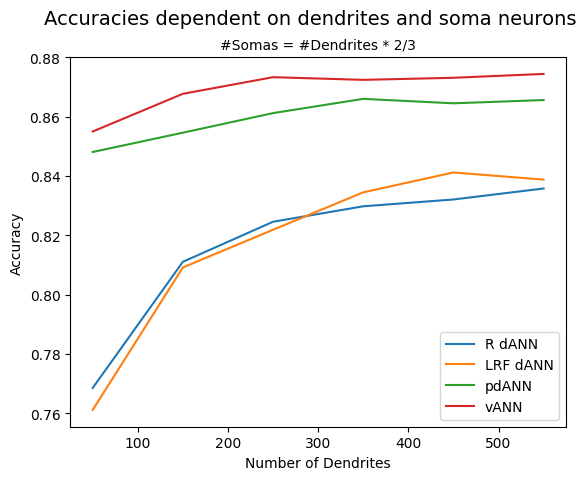

In [14]:
with open('trainResults2.json', 'r') as f:
    loaded_data = json.load(f)

model1_acc_develop = [i[-1] for i in loaded_data["model1_randomRCF_acc"]]
model1_testloss_develop  = [i[-1] for i in loaded_data["model1_randomRCF_tesloss"]]
model1_params_develop = loaded_data["model1_randomRCF_params"]

model2_acc_develop = [i[-1] for i in loaded_data["model2_localRCF_acc"]]
model2_testloss_develop  = [i[-1] for i in loaded_data["model2_localRCF_tesloss"]]
model2_params_develop = loaded_data["model2_localRCF_params"]

model3_acc_develop = [i[-1] for i in loaded_data["model3_fullRCF_acc"]]
model3_testloss_develop  = [i[-1] for i in loaded_data["model3_fullRCF_tesloss"]]
model3_params_develop = loaded_data["model3_fullRCF_params"]

model4_acc_develop = [i[-1] for i in loaded_data["model4_vANN_acc"]]
model4_testloss_develop  = [i[-1] for i in loaded_data["model4_vANN_tesloss"]]
model4_params_develop = loaded_data["model4_vANN_params"]

fig, ax = plt.subplots()
x = [50,150,250,350,450,550]
fig.suptitle("Accuracies dependent on dendrites and soma neurons", fontsize=14)
ax.set_title("#Somas = #Dendrites * 2/3", fontsize=10)
ax.set_xlabel("Number of Dendrites", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
ax.plot(x, model1_acc_develop, label = "R dANN")
ax.plot(x, model2_acc_develop, label = "LRF dANN")
ax.plot(x, model3_acc_develop, label = "pdANN")
ax.plot(x, model4_acc_develop, label = "vANN")
ax.legend(loc = "lower right")


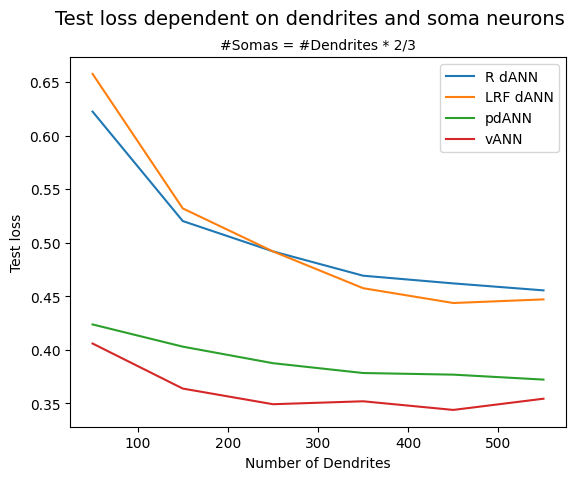

In [16]:
fig, ax = plt.subplots()
x = [50,150,250,350,450,550]
fig.suptitle("Test loss dependent on dendrites and soma neurons", fontsize=14)
ax.set_title("#Somas = #Dendrites * 2/3", fontsize=10)
ax.set_xlabel("Number of Dendrites", fontsize=10)
ax.set_ylabel("Test loss", fontsize=10)
ax.plot(x, model1_testloss_develop, label = "R dANN")
ax.plot(x, model2_testloss_develop, label = "LRF dANN")
ax.plot(x, model3_testloss_develop, label = "pdANN")
ax.plot(x, model4_testloss_develop, label = "vANN")
ax.legend(loc = "upper right")

Find the parameters that can be trained and are not zero within the neuronal net. Please notice that this code could also be implemented in the code above though I realized it after training. 
The previous calculation of parameters was useless as masks do not decrease the parameter space. 

In [18]:
import json 

params1_train_nonZero_random = []
params2_train_nonZero_local = []
params3_train_nonZero_full = []
params4_train_nonZero_vANN = []

for i in range(50,650,100):
    j = (2*i) // 3

    model1_randomRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="random")
    nonzero_params1 = 0
    for param in model1_randomRCF.parameters():
        if param.requires_grad:
            nonzero_params1 += torch.count_nonzero(param).item()
    params1_train_nonZero_random.append(nonzero_params1)

    model2_localRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="local")
    nonzero_params2 = 0
    for param in model2_localRCF.parameters():
        if param.requires_grad:
            nonzero_params2 += torch.count_nonzero(param).item()
    params2_train_nonZero_local.append(nonzero_params2)

    model3_fullRCF = NeuralNetwork(num_dendrites=i, num_somas=j,mask_type="full")
    nonzero_params3 = 0
    for param in model3_fullRCF.parameters():
        if param.requires_grad:
            nonzero_params3 += torch.count_nonzero(param).item()
    params3_train_nonZero_full.append(nonzero_params3)

    
    model4_vANN = NeuralNetwork(num_dendrites=i, num_somas=j, masking=False)
    nonzero_params4 = 0
    for param in model4_vANN.parameters():
        if param.requires_grad:
            nonzero_params4 += torch.count_nonzero(param).item()
    params4_train_nonZero_vANN.append(nonzero_params4)


data3 = {
    "params1_train_nonZero_random" : params1_train_nonZero_random,
    "params2_train_nonZero_local": params2_train_nonZero_local,
    "params3_train_nonZero_full" : params3_train_nonZero_full,
    "params4_train_nonZero_vANN" : params4_train_nonZero_vANN
}

with open('nonZero_params2.json', 'w') as f:
    json.dump(data3, f)

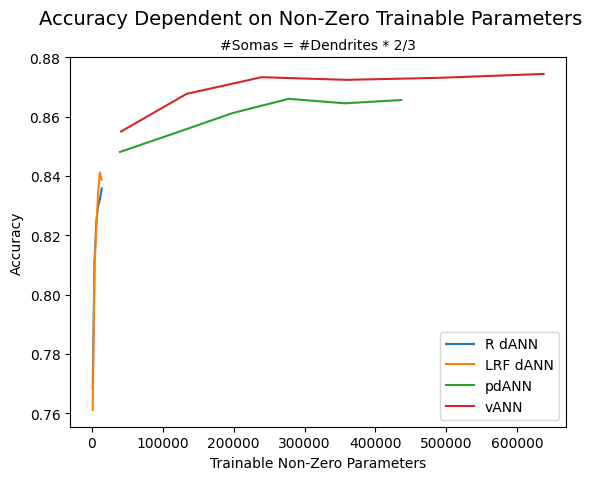

In [20]:
with open('nonZero_params2.json', 'r') as f:
    loaded_data2 = json.load(f)

fig, ax = plt.subplots()
params1_train_nonZero_random = loaded_data2["params1_train_nonZero_random"]
params2_train_nonZero_local = loaded_data2["params2_train_nonZero_local"]
params3_train_nonZero_full = loaded_data2["params3_train_nonZero_full"]
params4_train_nonZero_vANN = loaded_data2["params4_train_nonZero_vANN"]
fig.suptitle("Accuracy Dependent on Non-Zero Trainable Parameters", fontsize=14)
ax.set_title("#Somas = #Dendrites * 2/3", fontsize=10)
ax.set_xlabel("Trainable Non-Zero Parameters", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
ax.plot(params1_train_nonZero_random, model1_acc_develop, label = "R dANN")
ax.plot(params2_train_nonZero_local, model2_acc_develop, label = "LRF dANN")
ax.plot(params3_train_nonZero_full, model3_acc_develop, label = "pdANN")
ax.plot(params4_train_nonZero_vANN, model4_acc_develop, label = "vANN")
ax.legend(loc = "lower right")